# Context

This dataset describes about Customer acceptability evaluation. Buying an old car requires a lot of checks and tests. Many scenarios comes into picture when one is trying to purchase old car like Car condition, Safety, Buying Price, luggage boot size, maintenance. 

Making a correct decision while purchasing is not easy for all. Comparing with old data can make evaluation optimised. Here we are builiding a model on decision making whether we Customer go ahead and purchase or not.

Download the data from https://archive-beta.ics.uci.edu/ml/datasets/19

# Importing Required Modules

In [1]:
!pip install xgboost

In [2]:
!pip install kneed

In [3]:
!pip install imblearn

In [4]:
#importing Required Modules
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

#importing Graphical Charts Packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#importing ml models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier # Adaboost classifier
from xgboost import XGBClassifier # XGB Classifier

#importing cross validation module
from sklearn.model_selection import StratifiedKFold, cross_val_score

#importing train test split module
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

#importing metrics evaluation modules
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

# Reading Data

In [5]:
df  = pd.read_csv('car.data', header = None)
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep']
print(f"No of Instances : {df.shape[0]}")
print(f"No of Columns : {df.shape[1]}")

No of Instances : 1728
No of Columns : 7


pd.read_csv() used to import the dataset and it support various parameters ex. header. The data doesnt have any header so here header=None.
shape function provides dimensions of data(rows ,columns). index 0 contains no of instances and index 1 contains no of columns.


# Sample Data

In [6]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,accep
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


head() function prints top 5 records. Looking at top 5 records, below are observations

### Independent Variable
* buying : values contains text data
* maint : values contains text data
* doors : values contains numerical data
* persons : values contains numerical data
* lug_boot : values contains text data
* safety : values contains text data

### Dependent Variable
* accep : values contains text data

* Target variable is categorical data, we need to develop classification model.


# Looking at the data types and missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   accep     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


Text data is represented as **object** by default in pandas dataframe. Looking at dtype column, All of the columns are object data type and can be validated from the sample data. But doors, persons might have null values, they are being treated as object type, if they contain null values they supposed to be int type(looking at the sample data). Let's look at null values and decide whether or not to convert doors, persons to int type in the later section

In [8]:
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
accep       0
dtype: int64

Null values are missing values in the data. The null values are handled in feature extraction phase and those values are imputed with imputed values. From the above result, we can tell there are no null values in the data

# Since there are no null values, we manually add them into data

In [9]:
def add_null_values(df, columns, null_count):
    col_len = len(columns)
    total_instances = df.shape[0]
    
    while(null_count > 0) :
        random_column = columns[np.random.randint(0,col_len)]
        random_row = np.random.randint(0,total_instances)
        
        df[random_column][random_row] = np.nan
        null_count -=1


In [10]:
cols = ['buying', 'doors', 'safety','persons','maint', 'lug_boot']
add_null_values(df, cols, 130)

In [11]:
df.isna().sum()

buying      23
maint       21
doors       19
persons     30
lug_boot    21
safety      16
accep        0
dtype: int64

We have added few null values in the data, to perform feature engineering on the data in later section. In most cases, the raw data contains null values and we need to impute them with suitable values.Looks like we pulled a processed data from UCI Machine learning repo.

# EDA - Exploratory Data Analysis

EDA deals with charts and graphs on the data. EDA helps us to draw insights from the data, and also helps us to understand the data better. We use **matplotlib, seaborn** python packages to show the data through charts. 

In [12]:
df_copy = df.copy()
df_copy['accepted'] = np.where(df_copy['accep'] == 'unacc', 'not accepted', 'accepted')
df_copy.head(2)

,buying,maint,doors,persons,lug_boot,safety,accep,accepted
0,vhigh,vhigh,2,2,small,low,unacc,not accepted
1,vhigh,vhigh,2,2,small,med,unacc,not accepted


In [13]:
sns.set_style("whitegrid")
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
#color_palette = sns.color_palette("light:#5A9")
color_palette = sns.color_palette("ch:s=-.2,r=.6")
sns.set_palette(palette=color_palette)

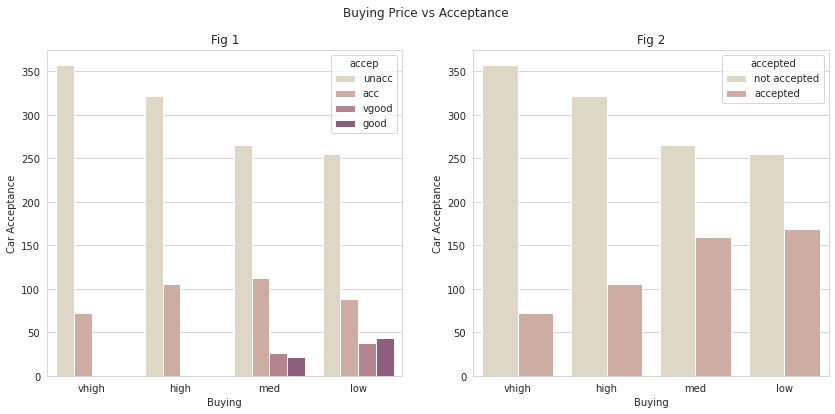

In [14]:
#df_accepted = df_copy[df_copy['accepted'] == 'accepted']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Buying Price vs Acceptance')

sns.countplot(ax=axes[0], x="buying",hue="accep", data=df_copy)
axes[0].set_xlabel("Buying")
axes[0].set_ylabel("Car Acceptance")
axes[0].set_title("Fig 1")
sns.countplot(ax=axes[1], x="buying",hue="accepted", data=df_copy)
axes[1].set_xlabel("Buying")
axes[1].set_ylabel("Car Acceptance")
axes[1].set_title("Fig 2")
plt.show()

Below are few keypoints observed from above chart between **buying** and **acceptance evaluation**. 
* Car is accepted even from lower price to very high price
* Car rejection rate decreasing and car acceptance rate increasing from vhigh to low
* Evaluation is having different levels when car buying price is low and medium. Looks like there are more changes of getting better deals at these prices.

In [15]:
df_copy['accepted_value'] = np.where(df_copy['accepted'] == 'not accepted', 0, 1)
df_copy.fillna("null_value", inplace=True)
df_copy.head(2)

,buying,maint,doors,persons,lug_boot,safety,accep,accepted,accepted_value
0,vhigh,vhigh,2,2,small,low,unacc,not accepted,0
1,vhigh,vhigh,2,2,small,med,unacc,not accepted,0


In [16]:
order = ["vhigh", "high", "med", "low", "null_value"]

accepted = df_copy[df_copy['accepted'] == 'accepted']
accepted_grp = accepted.groupby(['maint','buying'])['accepted'].count().unstack().astype(pd.Int64Dtype()).loc[order]

In [17]:
not_accepted = df_copy[df_copy['accepted'] == 'not accepted']
not_accepted_grp = not_accepted.groupby(['maint','buying'])['accepted'].count().unstack().astype(pd.Int64Dtype()).loc[order]

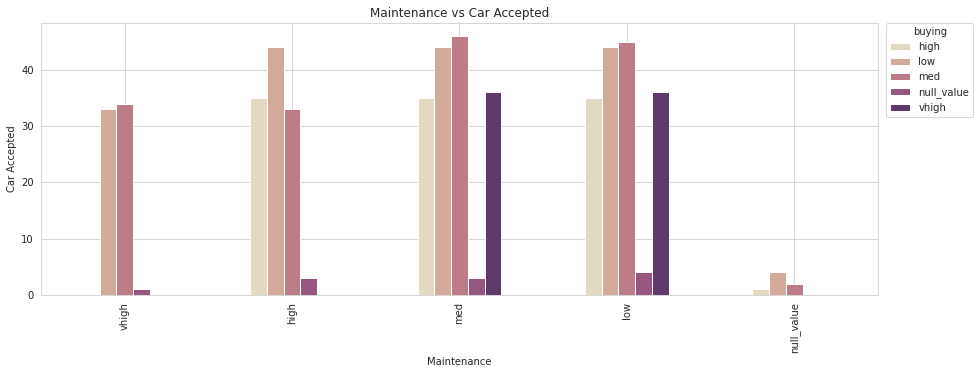

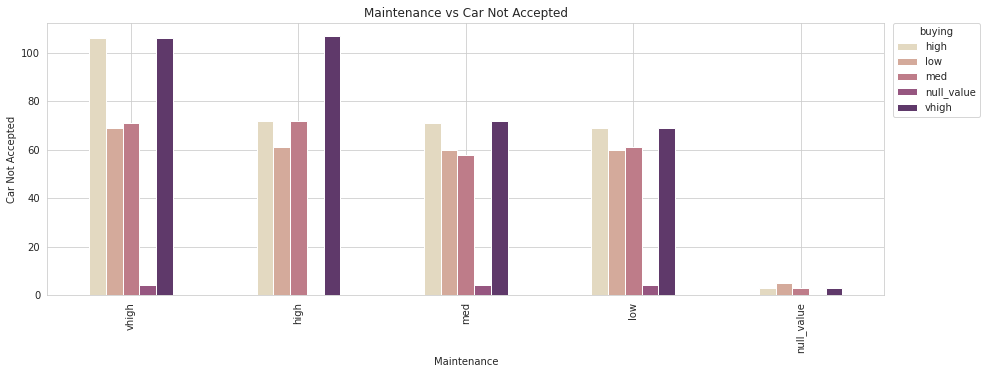

In [18]:
accepted_grp.plot(kind="bar", figsize=(15, 5), title="Maintenance vs Car Accepted", xlabel="Maintenance", ylabel="Car Accepted")
plt.legend(title = "buying", loc=(1.01,0.655));
not_accepted_grp.plot(kind="bar", figsize=(15, 5), title="Maintenance vs Car Not Accepted", xlabel="Maintenance", ylabel="Car Not Accepted")
plt.legend(title = "buying", loc=(1.01,0.655));

Keypoints:
##### Chart - Maintenance vs Car Accepted

* Maintenance is vhigh, and car should have low, medium price to accept.
* low, medium maintenance required cars can quote for high price.
* maintenance of null values have buying price low, high and vhigh. We should take care while imputing null values

##### Chart - Maintenance vs Car Not Accepted
* Car is not accepted at maintenance is vhigh, high even buying price is low, medium

In [19]:
doors_lug_boot_grouped = df_copy.groupby(['doors', 'lug_boot', 'accep'])

In [20]:
doors_lug_boot_acc = accepted.groupby(['doors', 'lug_boot'])['accepted'].count().unstack().astype(pd.Int64Dtype())
doors_lug_boot_unacc = not_accepted.groupby(['doors', 'lug_boot'])['accepted'].count().unstack().astype(pd.Int64Dtype())

In [21]:
doors_lug_boot_acc = accepted.groupby(['doors', 'lug_boot'])['accepted'].count()

In [22]:
#sns.relplot(x='doors', y='lug_boot', data=accepted.groupby(['doors', 'lug_boot'])['accepted'].count())

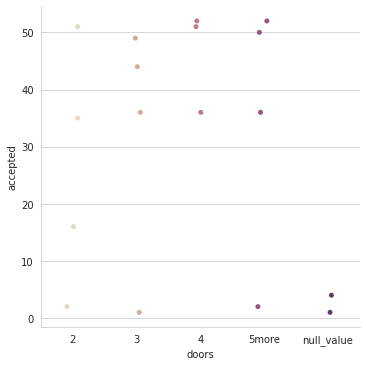

In [23]:

sns.catplot(x='doors', y='accepted', data=doors_lug_boot_acc.reset_index());
#plt.legend(loc=(1.01,0.85))
plt.show()

# Split the data 

We will do feature engineering, feature selection on the entire data and we learn about the data in this process. After that we split the data into training data and test data. We train our model using training data to learn the patterns and later test it with test data to check the accuracy. This looks simple and perfect right then why we need to split the data right now?

When we do EDA, feature engineering, feature selection on the entire data to identify underlying pattens in the data, and after we split data into training & test, there is a high chances of training data already known some patterns of test data and vice-versa as from starting phase we worked on entire data and it results in weak model and low accuracy


To ensure our model is working better and provide good results, We initally split the data into train data, test data in the initial phases. So we cannot understand the underlying pattern in the test data

In [24]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#for train_index, test_index in split.split(df, df["accep"]):
#    X_train, X_test = df.iloc[train_index,:-1], df.iloc[test_index,:-1]
#    y_train, y_test = df.iloc[train_index,-1], df.iloc[test_index,-1]

print(f"Instances in Training Set : {X_train.shape[0]}")
print(f"Instances in Test Set : {X_test.shape[0]}")

Instances in Training Set : 1382
Instances in Test Set : 346


# Describing the dataset

In [25]:
X_train.describe()

,buying,maint,doors,persons,lug_boot,safety
count,1364,1365,1369,1361,1364,1369
unique,4,4,4,3,3,3
top,med,high,2,4,big,low
freq,349,353,346,469,458,463


We are looking into insights about the data which helps in understanding the data statistically 
* unique tells how many unique values present in the data
* top tells top value in the data
* freq tells maximum repeated count of a value

But we knew doors and persons are not object data, lets understand the data and convert possible values to numeric, if required

In [26]:
#sns.barplot(x=X_train['buying'], y=y_train);

# Understanding Each Column data

In [27]:
X_train['doors'].unique()

array(['5more', '3', '4', '2', nan], dtype=object)

There is text **5more** in the data, but we knew maximum doors a car can have is 5. We have to fix '5more' and null values.

In [28]:
X_train['persons'].unique()

array(['more', '4', '2', nan], dtype=object)

**Person** data tells car seater type may be 2 seater, 4 seater, till 7 seater max. In the data we observed unique values 2,4, more and nan.2 means 2 seater , 4 means 4 seater  and for value **more** there is chance of 5, 6 or 7 seater. We need to fix this more value and also null in later part

In [29]:
X_train['buying'].unique()

array(['vhigh', 'med', 'low', 'high', nan], dtype=object)

Looks like **Buying** Column data is a categorical data and it is ordinal type because it has low, med, high etc. It represents the buying price of the car, the price is categorized from low to vhigh(very high). We need to give ranking to each of the value depending on their order (low < med < high < vhigh) and also null values needs to be imputed.

***What is Ordinal Data?***

The data is of type quantitative, categorized into different classes and there is a kind of order within the classes are Oridinal data. Below are examples
* Users rating apps in google play from 0 to 5.
* Ratings of restuarant food may be bad, average, tasty, awesome




In [30]:
X_train['maint'].unique()

array(['vhigh', 'low', 'med', 'high', nan], dtype=object)

Looks like **maint** Column data is a categorical data and it is ordinal type because it has low, med, high etc. It represents the car maintenance, it is categorized from low to vhigh(very high). We need to give ranking to each of the value depending on their order (low < med < high < vhigh) and also null values needs to be imputed.

In [31]:
X_train['lug_boot'].unique()

array(['big', 'small', 'med', nan], dtype=object)

**lug_boot** talks about the boot size in the car. The size will be different for each car and here it is categorized into small, med, big. It is ordinal data and need to assign numerical value depending on the order ( small < med < big) and also null values needs to be imputed.

In [32]:
X_train['safety'].unique()

array(['high', 'med', 'low', nan], dtype=object)

**Safety** column tells the car safety rating. It is classified into low, med, high and they are ordianal data. It also contains null values and we need to take care of them

In [33]:
y_train.unique()

array(['unacc', 'acc', 'vgood', 'good'], dtype=object)

Target variable is also categorized into **unacc**(unacceptable), **acc**(acceptable), **vgood**(very good), **good**(good). It is ordinal type. we have to convert all the ordinal varibles into numeric variables

***Why to convert from text data to numeric values?***

The Main reason to convert all text data to numeric is the machine learning model understands only integers. There are many ways to convert text to integers, we have encoders like 
* Label encoding or Ordinal encoding
* One hot encoding
* Dummy encoding
* Binary Encoding
* BaseN Encoding
* Hash Encoding
* Target Encoding

We will try to apply couple of encoding techniques in the feature engineering section to convert text data to numeric

Looking at scatter plot above between buying and accep data, we can make below observations
* When buying price is vhigh

# Feature Engineering

### Encoding Categorical Values

Let's Convert categorical value to numerical values as machine learning models understand numbers, looks like all the columns have categorical data but this is not the case for doors, persons features. We will handle these features a bit later 

In [34]:
real_cols = X_train.columns

In [35]:
encoder_features = ["buying","maint","lug_boot","safety"]
X_train[encoder_features].head()
for feature in encoder_features:
    print(f"{feature} feature unique values : ", X_train[feature].unique())

buying feature unique values :  ['vhigh' 'med' 'low' 'high' nan]
maint feature unique values :  ['vhigh' 'low' 'med' 'high' nan]
lug_boot feature unique values :  ['big' 'small' 'med' nan]
safety feature unique values :  ['high' 'med' 'low' nan]


From above observation, all the categorical features ordinal features

**Ordinal features:** Order of the values is important 

In [36]:
order_1 = dict((("vhigh",4), ("high",3), ("med",2), ("low",1), (np.nan, np.nan)))

def _encode_order_1(data, features):
    df = data.copy()
    for feature in features:
        df.loc[:,feature] = df[feature].apply(lambda x : order_1[x])
        
    return df
        
X_train = _encode_order_1(X_train, ["buying","maint"])
X_train.head()

,buying,maint,doors,persons,lug_boot,safety
107,4.0,4.0,5more,more,big,high
901,2.0,4.0,3,4,small,med
1709,1.0,1.0,5more,2,big,high
706,3.0,2.0,4,2,med,med
678,3.0,2.0,3,2,med,low


In [37]:
X_test = _encode_order_1(X_test, ["buying","maint"])

In [38]:
order_2 = dict((("high", 3), ("big",3), ("med",2), ("small",1), ("low",1), (np.nan, np.nan)))

def _encode_order_2(data, features):
    df = data.copy()
    for feature in features:
        df.loc[:,feature] = df[feature].apply(lambda x : order_2[x])
        
    return df
        
X_train = _encode_order_2(X_train, ["lug_boot","safety"])
X_train.head()

,buying,maint,doors,persons,lug_boot,safety
107,4.0,4.0,5more,more,3.0,3.0
901,2.0,4.0,3,4,1.0,2.0
1709,1.0,1.0,5more,2,3.0,3.0
706,3.0,2.0,4,2,2.0,2.0
678,3.0,2.0,3,2,2.0,1.0


In [39]:
X_test = _encode_order_2(X_test, ["lug_boot","safety"])

In [40]:
for feature in ["doors","persons"]:
    print(f"{feature} feature unique values : ", X_train[feature].unique())

doors feature unique values :  ['5more' '3' '4' '2' nan]
persons feature unique values :  ['more' '4' '2' nan]


Doors, and Persons features are nominal categorical features, we cannot apply one hot encoder right now as the column have null values.Let's replace text data to meaning numerical value, impute null values and after that we will apply one hot encoder values

In [41]:
X_train.loc[:,'doors'] = np.where(X_train['doors'] == "5more", 6, X_train['doors'])
X_train.loc[:,'persons'] = np.where(X_train['persons'] == "more", 6, X_train['persons'])    

In [42]:
X_test.loc[:,'doors'] = np.where(X_test['doors'] == "5more", 6, X_test['doors'])
X_test.loc[:,'persons'] = np.where(X_test['persons'] == "more", 6, X_test['persons'])    

In [43]:
def _convert_to_numeric(data):
    df = data.copy()
    for feature in data.columns:
        df[feature] = pd.to_numeric(df[feature], errors='coerce').astype('Int64')
    return df

X_train = _convert_to_numeric(X_train)
X_train.head()

,buying,maint,doors,persons,lug_boot,safety
107,4,4,6,6,3,3
901,2,4,3,4,1,2
1709,1,1,6,2,3,3
706,3,2,4,2,2,2
678,3,2,3,2,2,1


In [44]:
X_test = _convert_to_numeric(X_test)

In [45]:
print("*** Dtypes ***")
print(X_train[real_cols].dtypes)
print("*** Null Values ***")
print(X_train[real_cols].isna().sum())

*** Dtypes ***
buying      Int64
maint       Int64
doors       Int64
persons     Int64
lug_boot    Int64
safety      Int64
dtype: object
*** Null Values ***
buying      18
maint       17
doors       13
persons     21
lug_boot    18
safety      13
dtype: int64


All the features are in numeric values, lets apply knn imputer or mice imputer

### Imputing Null Values

In [46]:
na_columns = X_train[real_cols].isna().sum().index
X_train[na_columns].head()

,buying,maint,doors,persons,lug_boot,safety
107,4,4,6,6,3,3
901,2,4,3,4,1,2
1709,1,1,6,2,3,3
706,3,2,4,2,2,2
678,3,2,3,2,2,1


In [47]:
def _na_rows(data, features):
    df = data.copy()
    for feature in features:
        df[feature + '_na'] = np.where(df[feature].isna(), 1, 0)
        
    return df

X_train = _na_rows(X_train, na_columns)
print(f"Null values in training set : {X_train.isna().sum().sum()}")
X_train.head()

Null values in training set : 100


,buying,maint,doors,persons,lug_boot,safety,buying_na,maint_na,doors_na,persons_na,lug_boot_na,safety_na
107,4,4,6,6,3,3,0,0,0,0,0,0
901,2,4,3,4,1,2,0,0,0,0,0,0
1709,1,1,6,2,3,3,0,0,0,0,0,0
706,3,2,4,2,2,2,0,0,0,0,0,0
678,3,2,3,2,2,1,0,0,0,0,0,0


In [48]:
X_test = _na_rows(X_test, na_columns)

In [49]:
X_train['buying'].value_counts()

2    349
1    342
3    337
4    336
Name: buying, dtype: Int64

Looking at unique values for buying column, we cannot impute missing values with most occuring value because the four values frequencies are very close to each other. We can try using 
1. knn imputer
2. MICE imputer

we will create new feature to differentiate normal values vs imputed values

# Checking outliers

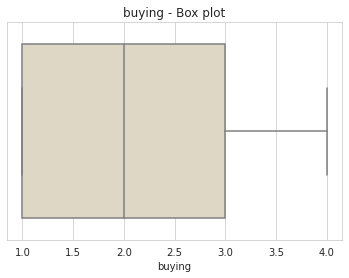

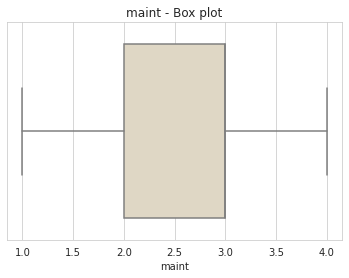

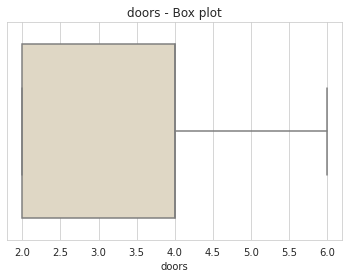

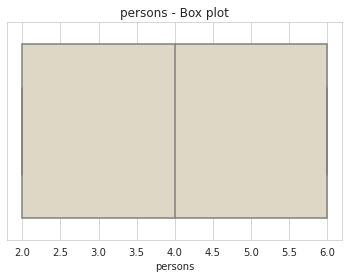

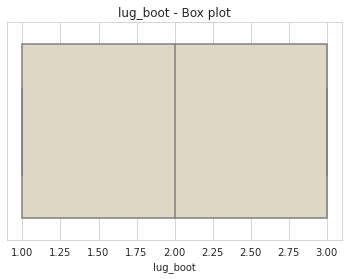

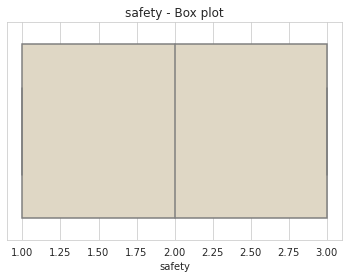

In [50]:
for feature in real_cols:
    plt.title(f"{feature} - Box plot")
    sns.boxplot(x= feature, data=X_train)
    plt.show()

In [51]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Imputing Null values using IterativeImputer

In [52]:
iter_imputer = IterativeImputer(random_state=42, verbose=2, missing_values=np.nan, 
                        initial_strategy='most_frequent')
iter_imputer.fit(X_train)
X_train_iter = iter_imputer.transform(X_train)
X_train_iter = pd.DataFrame(X_train_iter, columns=X_train.columns)
print(f"Missing values in train data set using Iterative imputer\n{X_train_iter.isna().sum()}")

[IterativeImputer] Completing matrix with shape (1382, 12)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.30
[IterativeImputer] Change: 2.740381385721931, scaled tolerance: 0.006 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.40
[IterativeImputer] Change: 0.0004572130024280696, scaled tolerance: 0.006 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1382, 12)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.01
Missing values in train data set using Iterative imputer
buying         0
maint          0
doors          0
persons        0
lug_boot       0
safety         0
buying_na      0
maint_na       0
doors_na       0
persons_na     0
lug_boot_na    0
safety_na      0
dtype: int64


In [53]:
X_test_iter = iter_imputer.transform(X_test)

[IterativeImputer] Completing matrix with shape (346, 12)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.00


### Handling Imbalanced Dataset

In [54]:
y_train.value_counts()/y_train.shape[0] * 100

unacc    70.549928
acc      21.780029
good      4.196816
vgood     3.473227
Name: accep, dtype: float64

looking at target variable, **unacc(1), acc(2)** accounts for 92% of training data and this is clear indication of biased data. We will handle the biased data using two methods **1. undersampling 2. Oversampling** methods from imblearn package
Applying underlying method, sample down the data  to make all categories value counts equal to least count whereas oversampling increase the data and make equal to maximum count values

In [55]:
y_train.value_counts()

unacc    975
acc      301
good      58
vgood     48
Name: accep, dtype: int64

In [56]:
#!pip install imblearn

In [57]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss 

In [58]:
ovr_spl = SMOTE(random_state=42)
undr_spl = NearMiss()

In [59]:
X_train_iter = X_train_iter.copy()
X_test_iter = X_test_iter.copy()

In [60]:
X_train_iter.shape, X_test_iter.shape, y_train.shape, y_test.shape

((1382, 12), (346, 12), (1382,), (346,))

In [61]:
y_train_cp = y_train.copy()

In [62]:
X_train_iter, y_train = ovr_spl.fit_resample(X_train_iter,y_train)
X_train_iter.shape

(3900, 12)

In [63]:
X_train_iter = pd.DataFrame(X_train_iter, columns=X_train.columns)

In [64]:
X_test_iter = pd.DataFrame(X_test_iter, columns=X_test.columns)

In [65]:
for feature in real_cols:
    print(f"{feature} feature unique values with Iter imputer : ", X_train_iter[feature].unique())
    #print(f"{feature} feature unique values with Iterative imputer : ", X_train_iter[feature].unique())

buying feature unique values with Iter imputer :  [4.         2.         1.         3.         2.48944562 2.4892653
 2.48944796 2.48708078 2.48819012 2.48775211 2.48773794 2.48956264
 2.48738117 2.48944981 2.48971492 2.4883946  2.48679924 2.49029452
 2.48672636 2.49168886 2.49001144 2.76719485 3.68103943 3.47771489
 3.43633583 2.19789075 2.6545778  1.95659922 2.07535667 3.07543455
 1.16621543 3.70550605 3.3945218  3.22939475 2.41120672 2.27095764
 3.07620038 1.41883738 3.08082345 1.87666149 2.7711137  1.83516574
 1.51962992 2.98528605 1.37673897 1.7495783  1.03682187 1.53434628
 3.27387916 2.37785055 3.24300087 3.02218474 3.4762107  3.63936136
 3.80504467 1.39191215 1.08952872 1.79647178 1.45934681 2.76891774
 2.57964993 3.8743176  1.48476395 3.97311035 1.4655765  3.35599148
 1.68778472 1.48834299 3.99740498 2.08451701 1.59727808 1.013743
 2.92404176 3.23611653 1.53126575 3.72051606 1.14773909 1.86721498
 2.39716383 1.56396509 2.84070999 3.4795821  2.44225773 2.2024168
 1.56445854 2.19

In [66]:
#X_train_knn = X_train_knn.apply(lambda x : np.int64(np.round(x)))
X_train_iter = X_train_iter.apply(lambda x : np.int64(np.round(x)))

In [67]:
#X_test_knn = X_test_knn.apply(lambda x : np.int64(np.round(x)))
X_test_iter = X_test_iter.apply(lambda x : np.int64(np.round(x)))

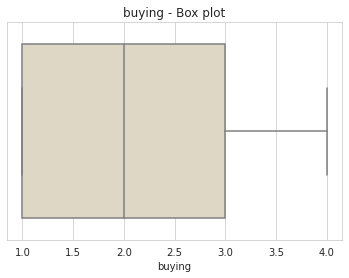

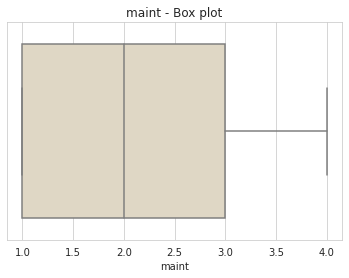

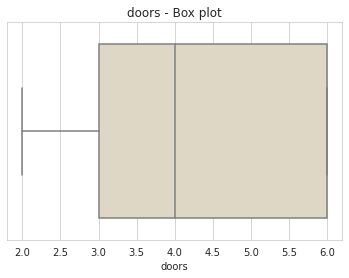

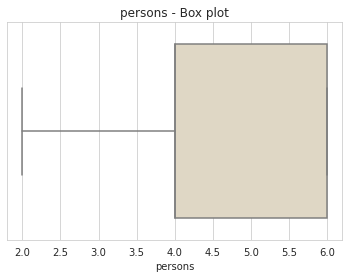

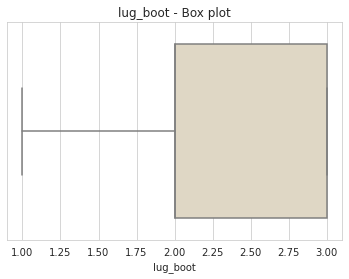

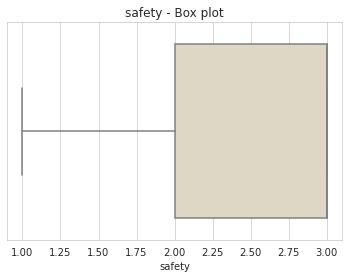

In [68]:
for feature in real_cols:
    plt.title(f"{feature} - Box plot")
    sns.boxplot(x= feature, data=X_train_iter)
    plt.show()

Since we imputed null values, let's handle nominal category data

In [69]:
X_train_iter.head()

,buying,maint,doors,persons,lug_boot,safety,buying_na,maint_na,doors_na,persons_na,lug_boot_na,safety_na
0,4,4,6,6,3,3,0,0,0,0,0,0
1,2,4,3,4,1,2,0,0,0,0,0,0
2,1,1,6,2,3,3,0,0,0,0,0,0
3,3,2,4,2,2,2,0,0,0,0,0,0
4,3,2,3,2,2,1,0,0,0,0,0,0


Encoding dependent variable by replace

In [70]:
y_train.unique()
order_3 = {'unacc' : 0, 'acc' : 1, 'good' : 2, 'vgood' : 3}
y_train.replace(order_3, inplace=True)

In [71]:
y_test.unique()
order_3 = {'unacc' : 0, 'acc' : 1, 'good' : 2, 'vgood' : 3}
y_test.replace(order_3, inplace=True)

Let's cluster the data before applying as clustering techniques have a disadvantage with nominal encoding

# Clustering the data points

In [72]:
from sklearn.cluster import KMeans

In [73]:
wcss = []
for cluster in range(1, 11):
    kmeans = KMeans(n_clusters=cluster, n_init=10, random_state=42)
    kmeans.fit(X_train_iter[real_cols])
    wcss.append(kmeans.inertia_)

Let's Plot the WCSS graph and identity K value 

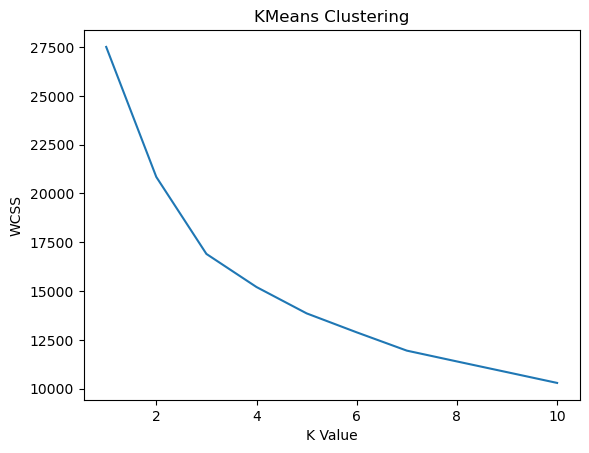

In [74]:
sns.reset_defaults()

plt.plot(range(1, 11), wcss)
plt.title("KMeans Clustering")
plt.xlabel("K Value")
plt.ylabel("WCSS")
plt.show()

looking from above elbow curve, we can consider k value between 4 to 6, let's get the k value from a KneeLocator method

In [75]:
from kneed import KneeLocator
knee = KneeLocator(range(1, 11), wcss, direction="decreasing", curve="convex")
k_value = knee.knee
print(f"K value from KneeLocator : {k_value}")

K value from KneeLocator : 3


In [76]:
kmeans = KMeans(n_clusters=k_value, n_init=10, random_state=42)
kmeans.fit(X_train_iter[real_cols])
clusters = kmeans.predict(X_train_iter[real_cols])

clusters_train = pd.Series(clusters)
clusters_train = pd.DataFrame(clusters, columns=['clusters'])
clusters_train.head()

,clusters
0,2
1,0
2,2
3,0
4,0


In [77]:
clusters_test = kmeans.predict(X_test_iter[real_cols])

clusters_test = pd.Series(clusters_test)
clusters_test = pd.DataFrame(clusters_test, columns=['clusters'])
clusters_test.head()

,clusters
0,0
1,0
2,2
3,2
4,1


In [78]:
clusters_test.shape

(346, 1)

In [79]:
nominal_categories = ["doors","persons","lug_boot"]
for feature in nominal_categories:
    print(f"{feature} unique values {X_train_iter[feature].unique()}")

doors unique values [6 3 4 2 5]
persons unique values [6 4 2 5]
lug_boot unique values [3 1 2]


Let's replace doors value (6) with others, as initially we replaced 'more' value with 6 for doors feature
Let's replace persons value (6) with others, as initially we replaced '5more' value with 6 for replace feature

for feature in nominal_categories:
    X_train_knn[feature] = X_train_knn[feature].apply(lambda x : feature + '_' + str(x).strip())
X_train_knn.head()

for feature in nominal_categories:
    X_test_knn[feature] = X_test_knn[feature].apply(lambda x : feature + '_' + str(x).strip())
#X_test_knn.head()

def _one_hot_encoder(data, nominal_categories):
    df = data.copy()
    for feature in nominal_categories:
        df = pd.concat([df, pd.get_dummies(df[feature], drop_first=True)], axis=1)
    return df
X_train_knn = _one_hot_encoder(X_train_knn, nominal_categories)
X_train_knn.head()

X_test_knn = _one_hot_encoder(X_test_knn, nominal_categories)

X_train_knn.drop(nominal_categories, axis=1, inplace=True)

X_test_knn.drop(nominal_categories, axis=1, inplace=True)

X_train_knn.head()

X_train_knn.rename(columns={"doors_6": "doors_more","persons_6": "persons_more"}, inplace=True)
X_train_knn.head()

X_test_knn.rename(columns={"doors_6": "doors_more","persons_6": "persons_more"}, inplace=True)

In [80]:
extra_cols = ["buying_na","maint_na","doors_na","persons_na","lug_boot_na","safety_na"]
X_train_iter.drop(extra_cols, axis=1, inplace=True)
X_train_iter.head()

,buying,maint,doors,persons,lug_boot,safety
0,4,4,6,6,3,3
1,2,4,3,4,1,2
2,1,1,6,2,3,3
3,3,2,4,2,2,2
4,3,2,3,2,2,1


In [81]:
extra_cols = ["buying_na","maint_na","doors_na","persons_na","lug_boot_na","safety_na"]
X_test_iter.drop(extra_cols, axis=1, inplace=True)

In [82]:
X_train_iter.shape, X_test_iter.shape, y_train.shape, y_test.shape

((3900, 6), (346, 6), (3900,), (346,))

In [83]:
X_train_iter.head()

,buying,maint,doors,persons,lug_boot,safety
0,4,4,6,6,3,3
1,2,4,3,4,1,2
2,1,1,6,2,3,3
3,3,2,4,2,2,2
4,3,2,3,2,2,1


Let's train our data with different models without cross-validation

In [84]:
from sklearn.ensemble import RandomForestClassifier # Random forest classifier

# Metrics packages
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import accuracy_score, make_scorer

In [85]:
rf_clf = RandomForestClassifier()

for test_feature in X_train_knn.columns:
    if test_feature not in X_test_knn:
        X_test_knn[test_feature] = 0

In [86]:
for model in [rf_clf]:
    print(f"model - {model}")
    model.fit(X_train_iter, y_train)
    y_pred = model.predict(X_test_iter)
    print(classification_report(y_pred=y_pred, y_true=y_test))

model - RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       235
           1       0.97      0.86      0.91        83
           2       0.56      0.91      0.69        11
           3       0.88      0.88      0.88        17

    accuracy                           0.96       346
   macro avg       0.85      0.91      0.87       346
weighted avg       0.96      0.96      0.96       346



In [87]:
for cluster in range(k_value):
    index = clusters_train[clusters_train['clusters'] == cluster].index
    print(f"Cluster - {cluster}")
    print(y_train.iloc[index].value_counts())

Cluster - 0
0    547
3    372
2    369
1    365
Name: accep, dtype: int64
Cluster - 1
2    340
1    340
3    273
0    201
Name: accep, dtype: int64
Cluster - 2
3    330
1    270
2    266
0    227
Name: accep, dtype: int64


Looking at target variable in traning set, all the target classes data points exists in all the clusters. So instead of traning individual cluster level, we will train all the data points at a time 


In [88]:
def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))# print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

In [89]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [90]:
def get_params(model):
    params = {}
    lg_params = {
        "max_iter" : np.arange(150, 300, 10),
        "multi_class" : ['ovr', 'multinomial'],
        "penalty" : ["l1", "l2", "elasticnet"],
        "solver" :['newton-cg', 'lbfgs', 'saga'],
        "C" : [10e-2, 10e-1, 1, 10, 100, 1000, 1000, 10000, 100000],
        "l1_ratio" : np.linspace(0.1, 0.5, 100)
    }


    rf_params = {
        "n_estimators" : np.arange(100, 2100, 100),
        "max_depth" : np.arange(5, 11,1),
        "min_samples_split" : np.arange(2,11, 2),
        "min_samples_leaf" : np.arange(3,10, 2),
        "max_leaf_nodes" : np.arange(3,10, 2),
        "max_features" : ['auto', 'sqrt'],
        "bootstrap" : [True, False]  
    }


    sgd_params = {
        'loss' : ['hinge', 'squared_hinge', 'log'],
        'penalty' : ['l1', 'l2', 'elasticnet'],
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
        'l1_ratio'  : np.arange(0.1, 0.55, 0.05),
        'max_iter'  : np.arange(700, 1200, 100)
    }

    xgb_params = {
        'eta' : np.arange(0.01, 0.3, 0.05),
        'max_depth' : np.arange(2, 7, 1),
        'n_estimators' : np.arange(700, 1300, 100),
        'objective' : ['multi:softmax'], 
        'num_class' : [4],
        'use_label_encoder' : [False],
        'eval_metric' : ['mlogloss']
    }
    params["lg_params"]  = lg_params
    params["rf_params"]  = rf_params
    params["sgd_params"] = sgd_params
    params["xgb_params"] = xgb_params
    return params[model]

In [91]:
from sklearn.metrics import accuracy_score, make_scorer

def classification_report_with_accuracy_score_train(y_true, y_pred):
    #print(classification_report(y_true, y_pred))# print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

def classification_report_with_accuracy_score_test(y_true, y_pred):
    print(classification_report(y_true, y_pred))# print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

In [92]:
accuracy = {}
best_params = {}
for cluster in range(0, k_value):
    
    model_accuracy = {}
    model_params = {}
    lg_regression = LogisticRegression(random_state=42)
    rf_clf = RandomForestClassifier(random_state=42)
    sgd_clf = SGDClassifier(random_state=42)
    xgboost = XGBClassifier(random_state=42)
    for model in [lg_regression, sgd_clf, xgboost, rf_clf]:
        if model == lg_regression : 
            params = get_params("lg_params")
        elif model == rf_clf : 
            params = get_params("rf_params")
        elif model == sgd_clf : 
            params = get_params("sgd_params")
        elif model == xgboost : 
            params = get_params("xgb_params")
        print(f"cluster : {cluster}, model : {model}")
        random_cv = RandomizedSearchCV(model, param_distributions=params, n_iter=15, cv=5, 
                               scoring=make_scorer(classification_report_with_accuracy_score_train), 
                               n_jobs=-1)
        random_cv.fit(X_train_iter, y_train)
        
        tuned_model = model.set_params(**random_cv.best_params_)
        tuned_model.fit(X_train_iter, y_train)
        index = clusters_test[clusters_test['clusters'] == cluster].index
        y_pred = tuned_model.predict(X_test_iter.iloc[index])
        if model == lg_regression:
            print(f"cluster : {cluster}, model : logistic")
            model_accuracy['lg_reg'] = classification_report_with_accuracy_score_test(y_pred=y_pred,y_true=y_test.iloc[index])
            model_params['lg_reg'] = random_cv.best_params_
        if model == rf_clf:
            print(f"cluster : {cluster}, model : random forest")
            model_accuracy['rf_reg'] = classification_report_with_accuracy_score_test(y_pred=y_pred,y_true=y_test.iloc[index])
            model_params['rf_reg'] = random_cv.best_params_
        if model == sgd_clf:
            print(f"cluster : {cluster}, model : SGD Classifier")
            model_accuracy['sgd_clf'] = classification_report_with_accuracy_score_test(y_pred=y_pred,y_true=y_test.iloc[index])
            model_params['sgd_clf'] = random_cv.best_params_
        if model == xgboost:
            print(f"cluster : {cluster}, model : XGB Classifier")
            model_accuracy['xgb_clf'] = classification_report_with_accuracy_score_test(y_pred=y_pred,y_true=y_test.iloc[index])
            model_params['xgb_clf'] = random_cv.best_params_
    accuracy[cluster] = model_accuracy
    best_params[cluster] = model_params

cluster : 0, model : LogisticRegression(random_state=42)


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


cluster : 0, model : logistic
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       129
           1       0.65      0.41      0.50        37
           2       0.27      0.80      0.40         5
           3       0.29      0.67      0.40         3

    accuracy                           0.77       174
   macro avg       0.52      0.69      0.54       174
weighted avg       0.80      0.77      0.77       174

cluster : 0, model : SGDClassifier(random_state=42)


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/p

cluster : 0, model : SGD Classifier
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       129
           1       0.69      0.30      0.42        37
           2       0.43      0.60      0.50         5
           3       0.33      0.33      0.33         3

    accuracy                           0.79       174
   macro avg       0.57      0.55      0.53       174
weighted avg       0.78      0.79      0.77       174

cluster : 0, model : XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
     

/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


cluster : 1, model : logistic
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        45
           1       0.64      0.82      0.72        28
           2       0.38      1.00      0.55         3
           3       0.83      1.00      0.91        10

    accuracy                           0.77        86
   macro avg       0.71      0.87      0.74        86
weighted avg       0.84      0.77      0.78        86

cluster : 1, model : SGDClassifier(random_state=42)


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/p

cluster : 1, model : SGD Classifier
              precision    recall  f1-score   support

           0       0.97      0.73      0.84        45
           1       0.66      0.82      0.73        28
           2       0.33      1.00      0.50         3
           3       0.88      0.70      0.78        10

    accuracy                           0.77        86
   macro avg       0.71      0.81      0.71        86
weighted avg       0.84      0.77      0.78        86

cluster : 1, model : XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
     

/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


cluster : 2, model : logistic
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        61
           1       0.63      0.94      0.76        18
           2       0.50      1.00      0.67         3
           3       0.75      0.75      0.75         4

    accuracy                           0.84        86
   macro avg       0.72      0.87      0.77        86
weighted avg       0.89      0.84      0.85        86

cluster : 2, model : SGDClassifier(random_state=42)


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/p

cluster : 2, model : SGD Classifier
              precision    recall  f1-score   support

           0       0.94      0.77      0.85        61
           1       0.57      0.72      0.63        18
           2       0.17      0.33      0.22         3
           3       0.57      1.00      0.73         4

    accuracy                           0.76        86
   macro avg       0.56      0.71      0.61        86
weighted avg       0.82      0.76      0.77        86

cluster : 2, model : XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
     

In [93]:
print(accuracy)

{0: {'lg_reg': 0.7701149425287356, 'sgd_clf': 0.7931034482758621, 'xgb_clf': 0.9655172413793104, 'rf_reg': 0.8850574712643678}, 1: {'lg_reg': 0.7674418604651163, 'sgd_clf': 0.7674418604651163, 'xgb_clf': 0.9767441860465116, 'rf_reg': 0.813953488372093}, 2: {'lg_reg': 0.8372093023255814, 'sgd_clf': 0.7558139534883721, 'xgb_clf': 0.9883720930232558, 'rf_reg': 0.9069767441860465}}


In [94]:
print(best_params)

{0: {'lg_reg': {'solver': 'saga', 'penalty': 'elasticnet', 'multi_class': 'multinomial', 'max_iter': 280, 'l1_ratio': 0.42727272727272725, 'C': 10}, 'sgd_clf': {'penalty': 'elasticnet', 'max_iter': 1100, 'loss': 'squared_hinge', 'l1_ratio': 0.1, 'alpha': 0.01}, 'xgb_clf': {'use_label_encoder': False, 'objective': 'multi:softmax', 'num_class': 4, 'n_estimators': 900, 'max_depth': 5, 'eval_metric': 'mlogloss', 'eta': 0.26}, 'rf_reg': {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_leaf_nodes': 9, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': False}}, 1: {'lg_reg': {'solver': 'saga', 'penalty': 'elasticnet', 'multi_class': 'multinomial', 'max_iter': 230, 'l1_ratio': 0.3666666666666667, 'C': 1.0}, 'sgd_clf': {'penalty': 'l1', 'max_iter': 800, 'loss': 'log', 'l1_ratio': 0.20000000000000004, 'alpha': 0.001}, 'xgb_clf': {'use_label_encoder': False, 'objective': 'multi:softmax', 'num_class': 4, 'n_estimators': 1200, 'max_depth': 6, 'eval_metric': 'mlogloss', 'e

We applied different models to each cluster and observed the below best models for each cluster

* cluster 0 - XG Boost with 96.55% accuracy
* cluster 1 - XG Boost with 97.67% accuracy
* cluster 2 - XG Boost with 98.83% accuracy

Best Hypertuned params for best fitted models for each cluster

* cluster - 0
#### 'xgb_clf': {'use_label_encoder': False, 'objective': 'multi:softmax', 'num_class': 4, 'n_estimators': 900, 'max_depth': 5, 'eval_metric': 'mlogloss', 'eta': 0.26}


* cluster - 1
#### 'xgb_clf': {'use_label_encoder': False, 'objective': 'multi:softmax', 'num_class': 4, 'n_estimators': 1200, 'max_depth': 6, 'eval_metric': 'mlogloss', 'eta': 0.26}

* cluster - 2
#### 'xgb_clf': {'use_label_encoder': False, 'objective': 'multi:softmax', 'num_class': 4, 'n_estimators': 1100, 'max_depth': 6, 'eval_metric': 'mlogloss', 'eta': 0.21000000000000002}

From initial model creation, we clearly see all the models couldn't predict the values properly. Then we applied hyper parameter tuning and divided our data into multiple clusters and trained 4 models with the training set. Finally we extracted best fitted model with hypertuned parameters. Let's use cross validation on the final model to see the accuaracy

## Cross- validation

Cross-validation is a technique in which we train our model using the subset of the data-set and then evaluate using the complementary subset of the data-set. There are different types of cross validation techniques. We use StratifiedKFold technique

In [95]:
hypertuned_parameters = {
    0: best_params[0]['xgb_clf'],
    1: best_params[1]['xgb_clf'],
    2: best_params[2]['xgb_clf'],
}    

In [96]:
def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))# print classification report
    return accuracy_score(y_true, y_pred)

In [99]:
avg_accuracy = []
for cluster in set(clusters):
    test_index = clusters_test[clusters_test['clusters'] == cluster].index
    params = hypertuned_parameters[cluster]
    model = XGBClassifier(random_state=42).set_params(**params)
    score = cross_val_score(model, X_train_iter, y_train, cv=5, scoring=make_scorer(classification_report_with_accuracy_score_train))
    print(f"Cluster - {cluster}", end=" & ")
    print(f"Accuracy Train Score - {score.mean()}")

Cluster - 0 & Accuracy Train Score - 0.9905128205128205
Cluster - 1 & Accuracy Train Score - 0.9910256410256411
Cluster - 2 & Accuracy Train Score - 0.9912820512820513


In [100]:
iter_avg_accuracy = []
models = []
for cluster in set(clusters):
    test_index = clusters_test[clusters_test['clusters'] == cluster].index
    #train_index = clusters_train[clusters_train['clusters'] == cluster].index
    params = hypertuned_parameters[cluster]
    model = XGBClassifier(random_state=42).set_params(**params)
    model.fit(X_train_iter, y_train)
    models.append(model)
    y_pred = model.predict(X_test_iter.iloc[test_index])
    print(f"Cluster - {cluster}", end=" & ")
    iter_avg_accuracy.append(accuracy_score(y_test.iloc[test_index], y_pred)*100)
    print(f"Accuracy Test Score - {iter_avg_accuracy[-1]}")
print(f"Model Average Accuracy - {sum(iter_avg_accuracy)/k_value}")

Cluster - 0 & Accuracy Test Score - 96.55172413793103
Cluster - 1 & Accuracy Test Score - 97.67441860465115
Cluster - 2 & Accuracy Test Score - 98.83720930232558
Model Average Accuracy - 97.68778401496924


Finally, our model final accuracy is 97.68% which is good accuracy

# Save the clustering logic and model

In [101]:
import pickle as pkl

Saving the cluster algorithm into cluster.pkl file, which can be re-used using pickle.load() method

In [102]:
cluster_file = open("cluster_imputer.pkl", "wb")
pkl.dump(kmeans, cluster_file)
cluster_file.close()

Saving the model into model.pkl file, which can be re-used using pickle.load() method

In [103]:
model_file = open("model_imputer.pkl", "wb")
pkl.dump(models, model_file)
model_file.close()

# Imputing Null values using KNN Imputer

In [104]:
knn_imputer = KNNImputer(n_neighbors = 3)
knn_imputer.fit(X_train)
X_train_knn = knn_imputer.transform(X_train)
X_train_knn = pd.DataFrame(X_train_knn, columns=X_train.columns)
print(f"Missing values in train data set using KNN imputer\n{X_train_knn.isna().sum()}")

Missing values in train data set using KNN imputer
buying         0
maint          0
doors          0
persons        0
lug_boot       0
safety         0
buying_na      0
maint_na       0
doors_na       0
persons_na     0
lug_boot_na    0
safety_na      0
dtype: int64


### Handling Imbalanced Dataset

In [105]:
y_train = y_train_cp.copy()

In [106]:
y_train.value_counts()/y_train.shape[0] * 100

unacc    70.549928
acc      21.780029
good      4.196816
vgood     3.473227
Name: accep, dtype: float64

looking at target variable, **unacc(1), acc(2)** accounts for 92% of training data and this is clear indication of biased data. We will handle the biased data using two methods **1. undersampling 2. Oversampling** methods from imblearn package
Applying underlying method, sample down the data  to make all categories value counts equal to least count whereas oversampling increase the data and make equal to maximum count values

In [107]:
y_train.value_counts()

unacc    975
acc      301
good      58
vgood     48
Name: accep, dtype: int64

In [108]:
#!pip install imblearn

In [109]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss 

In [110]:
ovr_spl = SMOTE(random_state=42)
undr_spl = NearMiss()

In [111]:
X_train_knn, y_train = ovr_spl.fit_resample(X_train_knn,y_train)
X_train_knn.shape

(3900, 12)

In [112]:
X_test_knn = knn_imputer.transform(X_test)

In [113]:
X_test_knn = pd.DataFrame(X_test_knn, columns=X_test.columns)

In [114]:
#X_train_knn = X_train_knn.apply(lambda x : np.int64(np.round(x)))
X_train_knn = X_train_knn.apply(lambda x : np.int64(np.round(x)))

In [115]:
#X_test_knn = X_test_knn.apply(lambda x : np.int64(np.round(x)))
X_test_knn = X_test_knn.apply(lambda x : np.int64(np.round(x)))

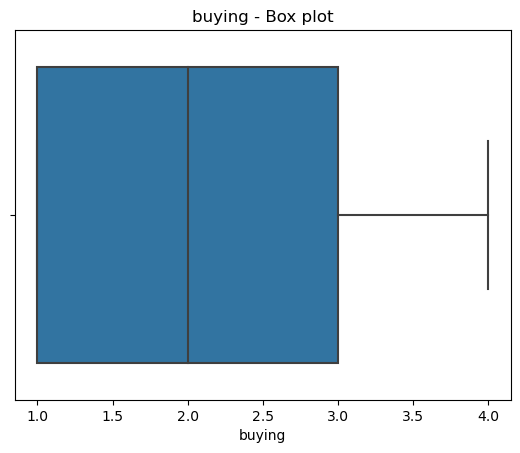

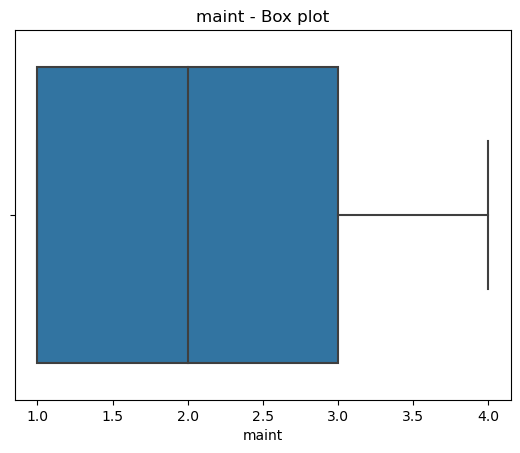

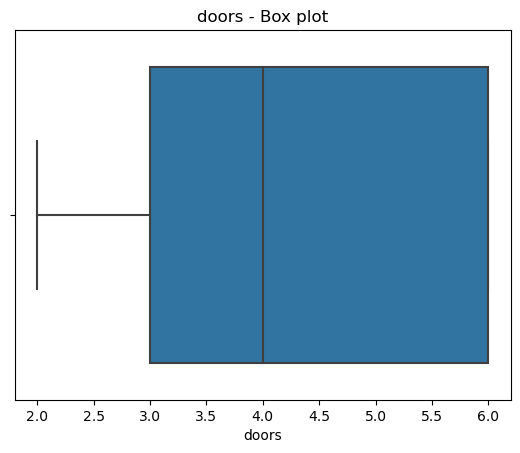

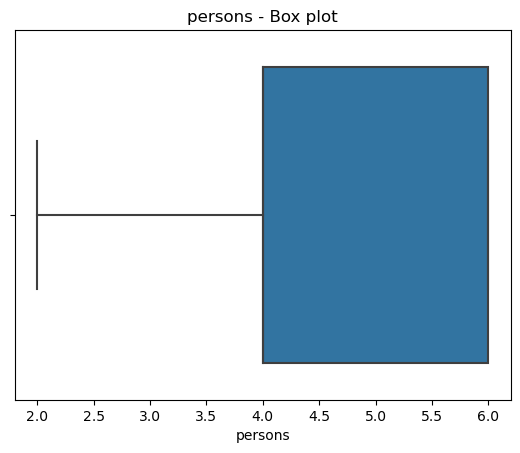

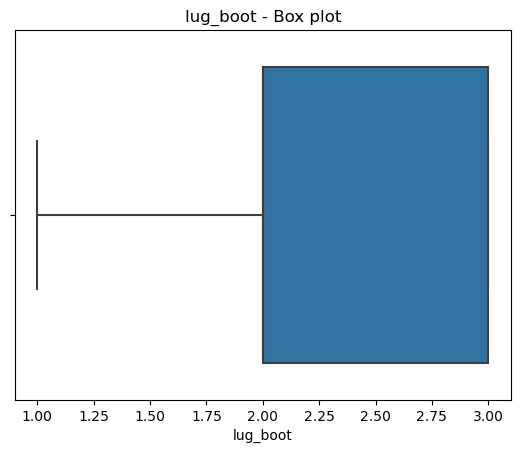

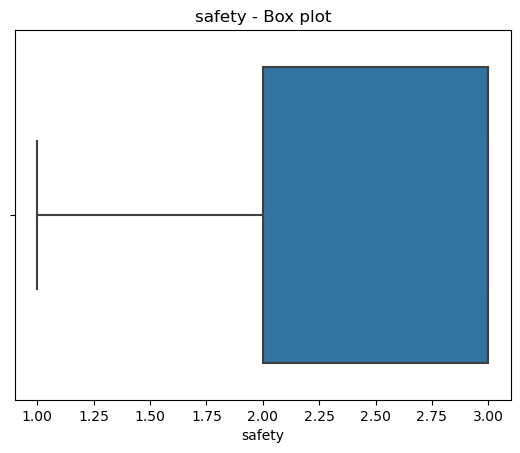

In [116]:
for feature in real_cols:
    plt.title(f"{feature} - Box plot")
    sns.boxplot(x= feature, data=X_train_knn)
    plt.show()

Since we imputed null values, let's handle nominal category data

In [117]:
X_train_knn.head()

,buying,maint,doors,persons,lug_boot,safety,buying_na,maint_na,doors_na,persons_na,lug_boot_na,safety_na
0,4,4,6,6,3,3,0,0,0,0,0,0
1,2,4,3,4,1,2,0,0,0,0,0,0
2,1,1,6,2,3,3,0,0,0,0,0,0
3,3,2,4,2,2,2,0,0,0,0,0,0
4,3,2,3,2,2,1,0,0,0,0,0,0


Encoding dependent variable by replace

In [118]:
y_train.unique()
order_3 = {'unacc' : 0, 'acc' : 1, 'good' : 2, 'vgood' : 3}
y_train.replace(order_3, inplace=True)

In [119]:
#y_test.unique()
#order_3 = {'unacc' : 0, 'acc' : 1, 'good' : 2, 'vgood' : 3}
#y_test.replace(order_3, inplace=True)

Let's cluster the data before applying as clustering techniques have a disadvantage with nominal encoding

# Clustering the data points

In [120]:
from sklearn.cluster import KMeans

In [121]:
wcss = []
for cluster in range(1, 11):
    kmeans = KMeans(n_clusters=cluster, n_init=10, random_state=42)
    kmeans.fit(X_train_knn[real_cols])
    wcss.append(kmeans.inertia_)

Let's Plot the WCSS graph and identity K value 

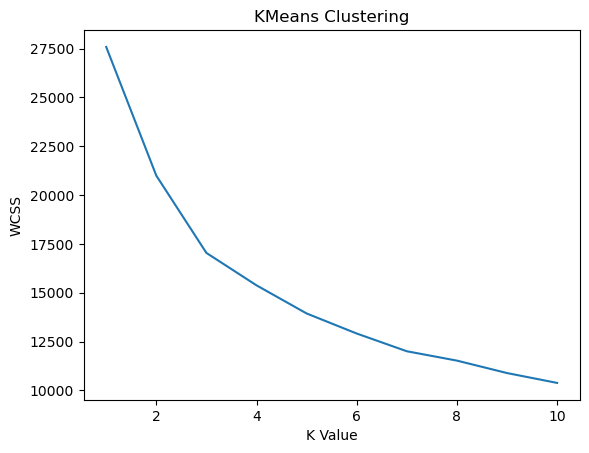

In [122]:
sns.reset_defaults()

plt.plot(range(1, 11), wcss)
plt.title("KMeans Clustering")
plt.xlabel("K Value")
plt.ylabel("WCSS")
plt.show()

looking from above elbow curve, we can consider k value between 4 to 6, let's get the k value from a KneeLocator method

In [123]:
from kneed import KneeLocator
knee = KneeLocator(range(1, 11), wcss, direction="decreasing", curve="convex")
k_value = knee.knee
print(f"K value from KneeLocator : {k_value}")

K value from KneeLocator : 3


In [124]:
kmeans = KMeans(n_clusters=k_value, n_init=10, random_state=42)
kmeans.fit(X_train_knn[real_cols])
clusters = kmeans.predict(X_train_knn[real_cols])

clusters_train = pd.Series(clusters)
clusters_train = pd.DataFrame(clusters, columns=['clusters'])
clusters_train.head()

,clusters
0,1
1,0
2,1
3,0
4,0


In [125]:
clusters_test = kmeans.predict(X_test_knn[real_cols])

clusters_test = pd.Series(clusters_test)
clusters_test = pd.DataFrame(clusters_test, columns=['clusters'])
clusters_test.head()

,clusters
0,0
1,0
2,1
3,1
4,2


In [126]:
clusters_test.shape

(346, 1)

In [127]:
nominal_categories = ["doors","persons","lug_boot"]
for feature in nominal_categories:
    print(f"{feature} unique values {X_train_knn[feature].unique()}")

doors unique values [6 3 4 2 5]
persons unique values [6 4 2 3 5]
lug_boot unique values [3 1 2]


Let's replace doors value (6) with others, as initially we replaced 'more' value with 6 for doors feature
Let's replace persons value (6) with others, as initially we replaced '5more' value with 6 for replace feature

for feature in nominal_categories:
    X_train_knn[feature] = X_train_knn[feature].apply(lambda x : feature + '_' + str(x).strip())
X_train_knn.head()

for feature in nominal_categories:
    X_test_knn[feature] = X_test_knn[feature].apply(lambda x : feature + '_' + str(x).strip())
#X_test_knn.head()

def _one_hot_encoder(data, nominal_categories):
    df = data.copy()
    for feature in nominal_categories:
        df = pd.concat([df, pd.get_dummies(df[feature], drop_first=True)], axis=1)
    return df
X_train_knn = _one_hot_encoder(X_train_knn, nominal_categories)
X_train_knn.head()

X_test_knn = _one_hot_encoder(X_test_knn, nominal_categories)

X_train_knn.drop(nominal_categories, axis=1, inplace=True)

X_test_knn.drop(nominal_categories, axis=1, inplace=True)

X_train_knn.head()

X_train_knn.rename(columns={"doors_6": "doors_more","persons_6": "persons_more"}, inplace=True)
X_train_knn.head()

X_test_knn.rename(columns={"doors_6": "doors_more","persons_6": "persons_more"}, inplace=True)

In [128]:
extra_cols = ["buying_na","maint_na","doors_na","persons_na","lug_boot_na","safety_na"]
X_train_knn.drop(extra_cols, axis=1, inplace=True)
X_train_knn.head()

,buying,maint,doors,persons,lug_boot,safety
0,4,4,6,6,3,3
1,2,4,3,4,1,2
2,1,1,6,2,3,3
3,3,2,4,2,2,2
4,3,2,3,2,2,1


In [129]:
extra_cols = ["buying_na","maint_na","doors_na","persons_na","lug_boot_na","safety_na"]
X_test_knn.drop(extra_cols, axis=1, inplace=True)

In [130]:
X_train_knn.shape, X_test_knn.shape, y_train.shape, y_test.shape

((3900, 6), (346, 6), (3900,), (346,))

In [131]:
X_train_knn.head()

,buying,maint,doors,persons,lug_boot,safety
0,4,4,6,6,3,3
1,2,4,3,4,1,2
2,1,1,6,2,3,3
3,3,2,4,2,2,2
4,3,2,3,2,2,1


Let's train our data with different models without cross-validation

In [132]:
from sklearn.ensemble import RandomForestClassifier # Random forest classifier

# Metrics packages
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import accuracy_score, make_scorer

In [133]:
rf_clf = RandomForestClassifier()

for test_feature in X_train_knn.columns:
    if test_feature not in X_test_knn:
        X_test_knn[test_feature] = 0

In [134]:
for model in [rf_clf]:
    print(f"model - {model}")
    model.fit(X_train_knn, y_train)
    y_pred = model.predict(X_test_knn)
    print(classification_report(y_pred=y_pred, y_true=y_test))

model - RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       235
           1       0.97      0.87      0.92        83
           2       0.47      0.82      0.60        11
           3       0.94      0.94      0.94        17

    accuracy                           0.96       346
   macro avg       0.84      0.91      0.86       346
weighted avg       0.97      0.96      0.96       346



In [135]:
for cluster in range(k_value):
    index = clusters_train[clusters_train['clusters'] == cluster].index
    print(f"Cluster - {cluster}")
    print(y_train.iloc[index].value_counts())

Cluster - 0
0    541
3    375
2    369
1    365
Name: accep, dtype: int64
Cluster - 1
3    325
1    270
2    265
0    229
Name: accep, dtype: int64
Cluster - 2
2    341
1    340
3    275
0    205
Name: accep, dtype: int64


Looking at target variable in traning set, all the target classes data points exists in all the clusters. So instead of traning individual cluster level, we will train all the data points at a time 


In [136]:
lg_regression = LogisticRegression()
rf_clf = RandomForestClassifier()
sgd_clf = SGDClassifier()
xgboost = XGBClassifier()

In [137]:
def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))# print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

In [138]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [139]:
def get_params(model):
    params = {}
    lg_params = {
        "max_iter" : np.arange(150, 300, 10),
        "multi_class" : ['ovr', 'multinomial'],
        "penalty" : ["l1", "l2", "elasticnet"],
        "solver" :['newton-cg', 'lbfgs', 'saga'],
        "C" : [10e-2, 10e-1, 1, 10, 100, 1000, 1000, 10000, 100000],
        "l1_ratio" : np.linspace(0.1, 0.5, 100)
    }


    rf_params = {
        "n_estimators" : np.arange(100, 2100, 100),
        "max_depth" : np.arange(5, 11,1),
        "min_samples_split" : np.arange(2,11, 2),
        "min_samples_leaf" : np.arange(3,10, 2),
        "max_leaf_nodes" : np.arange(3,10, 2),
        "max_features" : ['auto', 'sqrt'],
        "bootstrap" : [True, False]  
    }


    sgd_params = {
        'loss' : ['hinge', 'squared_hinge', 'log'],
        'penalty' : ['l1', 'l2', 'elasticnet'],
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
        'l1_ratio'  : np.arange(0.1, 0.55, 0.05),
        'max_iter'  : np.arange(700, 1200, 100)
    }

    xgb_params = {
        'eta' : np.arange(0.01, 0.3, 0.05),
        'max_depth' : np.arange(2, 7, 1),
        'n_estimators' : np.arange(700, 1300, 100),
        'objective' : ['multi:softmax'], 
        'num_class' : [4],
        'use_label_encoder' : [False],
        'eval_metric' : ['mlogloss']
    }
    params["lg_params"]  = lg_params
    params["rf_params"]  = rf_params
    params["sgd_params"] = sgd_params
    params["xgb_params"] = xgb_params
    return params[model]

In [140]:
lg_regression = LogisticRegression(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
sgd_clf = SGDClassifier(random_state=42)
xgboost = XGBClassifier(random_state=42)

In [141]:
from sklearn.metrics import accuracy_score, make_scorer

def classification_report_with_accuracy_score_train(y_true, y_pred):
    #print(classification_report(y_true, y_pred))# print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

def classification_report_with_accuracy_score_test(y_true, y_pred):
    print(classification_report(y_true, y_pred))# print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

In [142]:
accuracy = {}
best_params = {}
for cluster in range(0, k_value):
    index = clusters_train[clusters_train['clusters'] == cluster].index
    model_accuracy = {}
    model_params = {}
    lg_regression = LogisticRegression(random_state=42)
    rf_clf = RandomForestClassifier(random_state=42)
    sgd_clf = SGDClassifier(random_state=42)
    xgboost = XGBClassifier(random_state=42)
    for model in [lg_regression, sgd_clf, xgboost, rf_clf]:
        if model == lg_regression : 
            params = get_params("lg_params")
        elif model == rf_clf : 
            params = get_params("rf_params")
        elif model == sgd_clf : 
            params = get_params("sgd_params")
        elif model == xgboost : 
            params = get_params("xgb_params")
        print(f"cluster : {cluster}, model : {model}")
        random_cv = RandomizedSearchCV(model, param_distributions=params, n_iter=15, cv=5, 
                               scoring=make_scorer(classification_report_with_accuracy_score_train), 
                               n_jobs=-1)
        random_cv.fit(X_train_knn, y_train)
        
        tuned_model = model.set_params(**random_cv.best_params_)
        tuned_model.fit(X_train_knn, y_train)
        index = clusters_test[clusters_test['clusters'] == cluster].index
        y_pred = tuned_model.predict(X_test_knn.iloc[index])
        if model == lg_regression:
            print(f"cluster : {cluster}, model : logistic")
            model_accuracy['lg_reg'] = classification_report_with_accuracy_score_test(y_pred=y_pred,y_true=y_test.iloc[index])
            model_params['lg_reg'] = random_cv.best_params_
        if model == rf_clf:
            print(f"cluster : {cluster}, model : random forest")
            model_accuracy['rf_reg'] = classification_report_with_accuracy_score_test(y_pred=y_pred,y_true=y_test.iloc[index])
            model_params['rf_reg'] = random_cv.best_params_
        if model == sgd_clf:
            print(f"cluster : {cluster}, model : SGD Classifier")
            model_accuracy['sgd_clf'] = classification_report_with_accuracy_score_test(y_pred=y_pred,y_true=y_test.iloc[index])
            model_params['sgd_clf'] = random_cv.best_params_
        if model == xgboost:
            print(f"cluster : {cluster}, model : XGB Classifier")
            model_accuracy['xgb_clf'] = classification_report_with_accuracy_score_test(y_pred=y_pred,y_true=y_test.iloc[index])
            model_params['xgb_clf'] = random_cv.best_params_
    accuracy[cluster] = model_accuracy
    best_params[cluster] = model_params

cluster : 0, model : LogisticRegression(random_state=42)


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_mode

cluster : 0, model : logistic
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       128
           1       0.71      0.42      0.53        36
           2       0.21      0.80      0.33         5
           3       0.25      0.67      0.36         3

    accuracy                           0.76       172
   macro avg       0.51      0.68      0.52       172
weighted avg       0.81      0.76      0.77       172

cluster : 0, model : SGDClassifier(random_state=42)


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/p

cluster : 0, model : SGD Classifier
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       128
           1       0.76      0.44      0.56        36
           2       0.27      0.80      0.40         5
           3       0.20      0.67      0.31         3

    accuracy                           0.79       172
   macro avg       0.53      0.70      0.54       172
weighted avg       0.84      0.79      0.80       172

cluster : 0, model : XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
     

/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


cluster : 1, model : logistic
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        61
           1       0.62      0.83      0.71        18
           2       0.38      1.00      0.55         3
           3       0.80      1.00      0.89         4

    accuracy                           0.83        86
   macro avg       0.70      0.91      0.76        86
weighted avg       0.89      0.83      0.84        86

cluster : 1, model : SGDClassifier(random_state=42)


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/p

cluster : 1, model : SGD Classifier
              precision    recall  f1-score   support

           0       0.98      0.82      0.89        61
           1       0.65      0.61      0.63        18
           2       0.27      1.00      0.43         3
           3       0.57      1.00      0.73         4

    accuracy                           0.79        86
   macro avg       0.62      0.86      0.67        86
weighted avg       0.87      0.79      0.81        86

cluster : 1, model : XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
     

/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


cluster : 2, model : logistic
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        46
           1       0.67      0.83      0.74        29
           2       0.38      1.00      0.55         3
           3       0.83      1.00      0.91        10

    accuracy                           0.78        88
   macro avg       0.72      0.88      0.75        88
weighted avg       0.85      0.78      0.79        88

cluster : 2, model : SGDClassifier(random_state=42)


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/envs/fastai/lib/p

cluster : 2, model : SGD Classifier
              precision    recall  f1-score   support

           0       1.00      0.46      0.63        46
           1       0.59      0.83      0.69        29
           2       0.18      1.00      0.30         3
           3       0.89      0.80      0.84        10

    accuracy                           0.64        88
   macro avg       0.66      0.77      0.61        88
weighted avg       0.82      0.64      0.66        88

cluster : 2, model : XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
     

In [143]:
print(accuracy)

{0: {'lg_reg': 0.7558139534883721, 'sgd_clf': 0.7906976744186046, 'xgb_clf': 0.9709302325581395, 'rf_reg': 0.8953488372093024}, 1: {'lg_reg': 0.8255813953488372, 'sgd_clf': 0.7906976744186046, 'xgb_clf': 0.9883720930232558, 'rf_reg': 0.8837209302325582}, 2: {'lg_reg': 0.7840909090909091, 'sgd_clf': 0.6363636363636364, 'xgb_clf': 0.9431818181818182, 'rf_reg': 0.8068181818181818}}


In [144]:
print(best_params)

{0: {'lg_reg': {'solver': 'saga', 'penalty': 'elasticnet', 'multi_class': 'multinomial', 'max_iter': 260, 'l1_ratio': 0.4232323232323232, 'C': 100}, 'sgd_clf': {'penalty': 'elasticnet', 'max_iter': 700, 'loss': 'log', 'l1_ratio': 0.25000000000000006, 'alpha': 0.001}, 'xgb_clf': {'use_label_encoder': False, 'objective': 'multi:softmax', 'num_class': 4, 'n_estimators': 900, 'max_depth': 6, 'eval_metric': 'mlogloss', 'eta': 0.21000000000000002}, 'rf_reg': {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_leaf_nodes': 9, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}}, 1: {'lg_reg': {'solver': 'saga', 'penalty': 'elasticnet', 'multi_class': 'multinomial', 'max_iter': 290, 'l1_ratio': 0.12828282828282828, 'C': 1000}, 'sgd_clf': {'penalty': 'l1', 'max_iter': 700, 'loss': 'log', 'l1_ratio': 0.3500000000000001, 'alpha': 0.001}, 'xgb_clf': {'use_label_encoder': False, 'objective': 'multi:softmax', 'num_class': 4, 'n_estimators': 900, 'max_depth': 6, 'eval_m

We applied different models to each cluster and observed the below best models for each cluster

* cluster 0 - XG Boost with 97.09% accuracy
* cluster 1 - XG Boost with 98.83% accuracy
* cluster 2 - XG Boost with 94.31% accuracy

Best Hypertuned params for best fitted models for each cluster

* cluster - 0
#### 'xgb_clf': {'use_label_encoder': False, 'objective': 'multi:softmax', 'num_class': 4, 'n_estimators': 900, 'max_depth': 6, 'eval_metric': 'mlogloss', 'eta': 0.21000000000000002}


* cluster - 1
#### 'xgb_clf': {'use_label_encoder': False, 'objective': 'multi:softmax', 'num_class': 4, 'n_estimators': 900, 'max_depth': 6, 'eval_metric': 'mlogloss', 'eta': 0.21000000000000002}

* cluster - 2
#### 'xgb_clf': {'use_label_encoder': False, 'objective': 'multi:softmax', 'num_class': 4, 'n_estimators': 1200, 'max_depth': 6, 'eval_metric': 'mlogloss', 'eta': 0.21000000000000002}

From initial model creation, we clearly see all the models couldn't predict the values properly. Then we applied hyper parameter tuning and divided our data into multiple clusters and trained 4 models with the training set. Finally we extracted best fitted model with hypertuned parameters. Let's use cross validation on the final model to see the accuaracy

## Cross- validation

Cross-validation is a technique in which we train our model using the subset of the data-set and then evaluate using the complementary subset of the data-set. There are different types of cross validation techniques. We use StratifiedKFold technique

In [145]:
hypertuned_parameters = {
    0: best_params[0]['xgb_clf'],
    1: best_params[1]['xgb_clf'],
    2: best_params[2]['xgb_clf'],
}    

In [146]:
def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))# print classification report
    return accuracy_score(y_true, y_pred)

In [147]:
avg_accuracy = []
for cluster in set(clusters):
    test_index = clusters_test[clusters_test['clusters'] == cluster].index
    params = hypertuned_parameters[cluster]
    model = XGBClassifier(random_state=42).set_params(**params)
    score = cross_val_score(model, X_train_knn, y_train, cv=5, scoring=make_scorer(classification_report_with_accuracy_score_train))
    print(f"Cluster - {cluster}", end=" & ")
    print(f"Accuracy Train Score - {score.mean()}")

Cluster - 0 & Accuracy Train Score - 0.9884615384615385
Cluster - 1 & Accuracy Train Score - 0.9884615384615385
Cluster - 2 & Accuracy Train Score - 0.9887179487179487


In [148]:
avg_knn_accuracy = []
models = []
for cluster in set(clusters):
    test_index = clusters_test[clusters_test['clusters'] == cluster].index
    #train_index = clusters_train[clusters_train['clusters'] == cluster].index
    params = hypertuned_parameters[cluster]
    model = XGBClassifier(random_state=42).set_params(**params)
    model.fit(X_train_knn, y_train)
    models.append(model)
    y_pred = model.predict(X_test_knn.iloc[test_index])
    print(f"Cluster - {cluster}", end=" & ")
    avg_knn_accuracy.append(accuracy_score(y_test.iloc[test_index], y_pred)*100)
    print(f"Accuracy Test Score - {avg_knn_accuracy[-1]}")
print(f"Model Average Accuracy - {sum(avg_knn_accuracy)/k_value}")

Cluster - 0 & Accuracy Test Score - 97.09302325581395
Cluster - 1 & Accuracy Test Score - 98.83720930232558
Cluster - 2 & Accuracy Test Score - 94.31818181818183
Model Average Accuracy - 96.74947145877378


Finally, our model final accuracy is 96.74% which is good accuracy

Saving the cluster algorithm into cluster.pkl file, which can be re-used using pickle.load() method

In [149]:
cluster_file = open("cluster_knn.pkl", "wb")
pkl.dump(kmeans, cluster_file)
cluster_file.close()

Saving the model into model.pkl file, which can be re-used using pickle.load() method

In [150]:
model_file = open("model_knn.pkl", "wb")
pkl.dump(models, model_file)
model_file.close()